# <span style="color:blue">Project title/2: "Forecasting the number of antidiabetic drug prescriptions in Australia</span>

## <span style="color:brown">1. Data Collection & Project Presentation</span>

<div class="alert alert-block alert-info"><p> The data we wll use was recorded by the Australian Health Insurance Commission and made available on the book <b>"Time Series Forecasting in python" by Marco Peixeiro</b>. It is a monthly time series of the antidiabetic drug prescriptions from the year 1991 to 2008.</p><br>

<b>Content</b>

 |Data label|Data Type|Data Description|
|----------|----------|----------------|
|ds|object|time given in year, Month and day.|
|y|Numeric|number of antidiabetic drug prescriptions.|

<p><b>The purpose of this capstone project</b> is to apply the appropriate statistical model in order to forecast the 36 last months of the antidiabetic drug prescriptions. We will be using a systematic modelling approach as taught in the book previously quoted!</p></div>

## <span style="color:brown">2. Modelling</span>

In [1]:
# let's important the necessary libraries
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
# let's load the data on the Jupyter notebook interface!

df = pd.read_csv(r'C:\Users\HP\pyfold\data_ts\AusAntidiabeticDrug.csv')
df.head()

,ds,y
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


In [4]:
# check the number of rows
df.shape

(204, 2)

In [5]:
# verify that both variables have the appropriate data type
df.dtypes

ds     object
y     float64
dtype: object

we are not going to change the data type of 'ds' variable as the main target variable is 'y' and float is a perfect data type

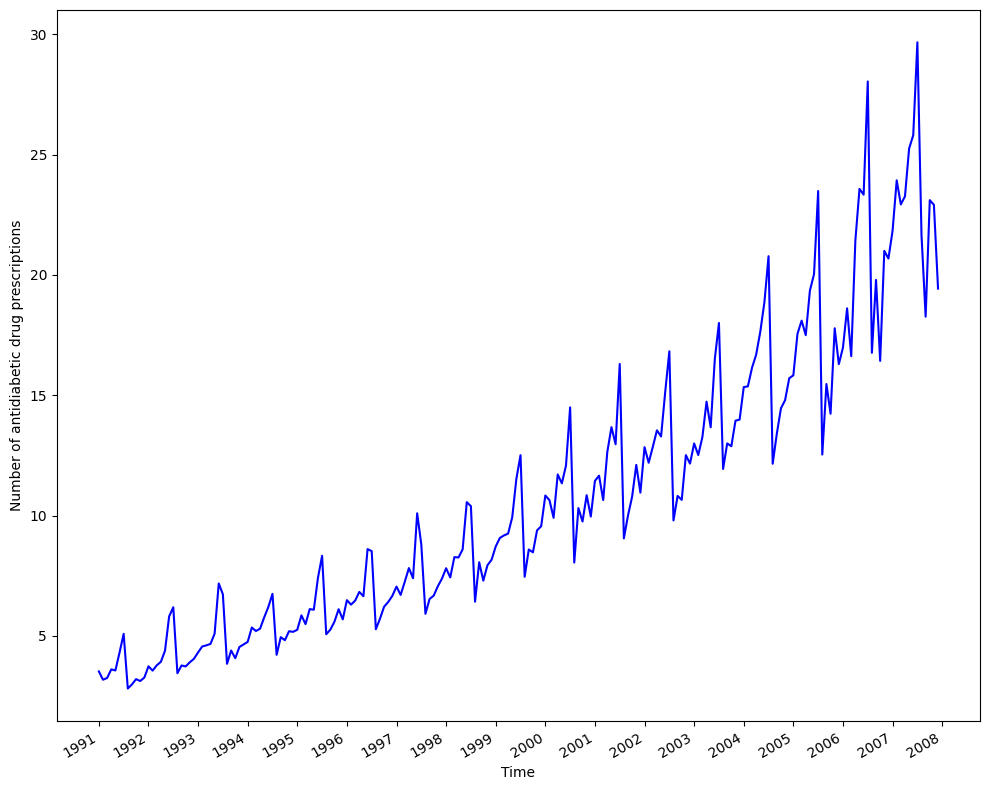

In [26]:
# let's visualize the dataset

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(df['y'], 'b-')

ax.set_xlabel('Time')
ax.set_ylabel('Number of antidiabetic drug prescriptions')

plt.xticks(np.arange(0, 216, 12), np.arange(1991, 2009, 1))

fig.autofmt_xdate()
plt.tight_layout()

a clear trend and seasonality is visible. let's decompose the series to visualize each component separately

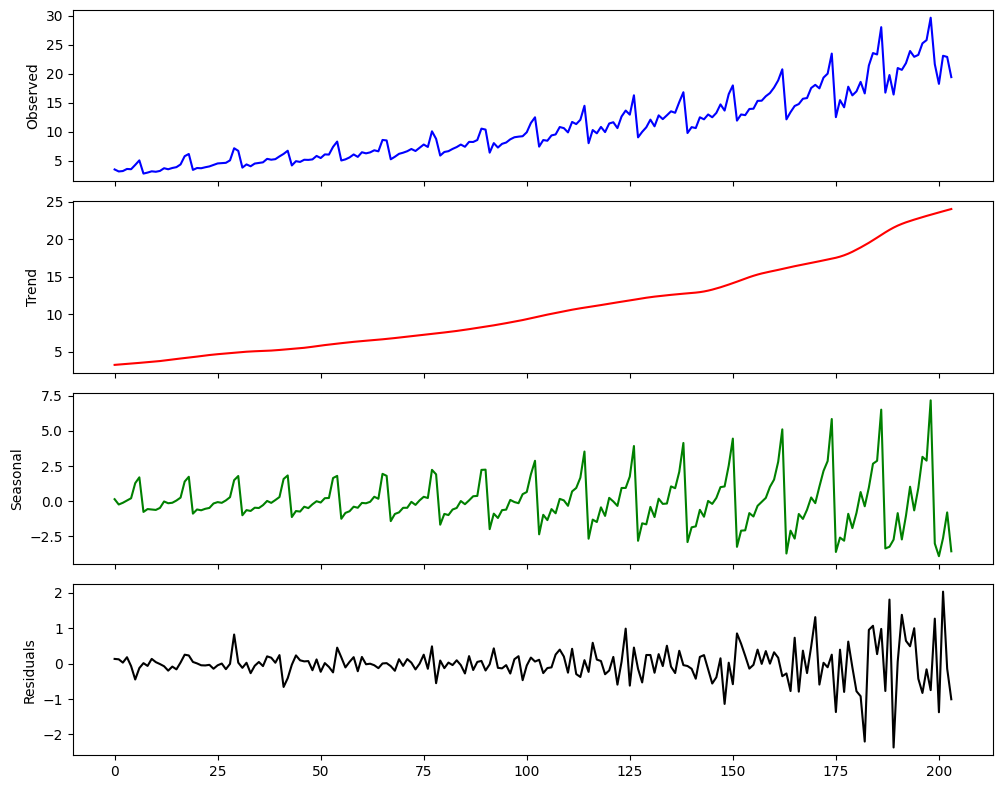

In [7]:
decomposition = STL(df['y'], period = 12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed, 'b-')
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend, 'r-')
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal, 'g-')
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid, 'k-')
ax4.set_ylabel('Residuals')

plt.tight_layout()

In [8]:
# let's check the stationarity with the Augmented Dickey Fuller Test (ADF)

ad_fuller_result = adfuller(df['y'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 3.145185689306745
p-value: 1.0


In [9]:
# let's perform a one-order differencing since the series is clearly not stationary

diff_df =  np.diff(df['y'], n=1)
ad_fuller_result = adfuller(diff_df)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.4951721474497286
p-value: 0.1166534168646905


In [10]:
# the series is still not stationary, let's move on with  seasonal differencing

diff_seasonal_df =  np.diff(df['y'], n=12)
ad_fuller_result = adfuller(diff_seasonal_df)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -18.77966995490318
p-value: 2.0243648094331623e-30


<p>the ADF statistics is a very large negative number and p-value<0.05, we can therfore reject the null hypothesis stating there is a unit root. The series is now stationary, we can set the parameters:<br></p>
<p><b>d = 1</p><br></b>
<b>D = 1</b>
    

In [12]:
# let's split the data into train and test sets

train =  df[:-36]
test = df[-36:]

print(len(train), len(test))

168 36


In [13]:
#let's select the appropriate model based upon the lowest Akaike Information Criteria (AIC) 
#we define a fucntion to perform a grid search

def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [15]:
# let's create a list of possible values of the parameters p, q, P and Q

ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

d=1
D=1
s=12  #the data is recorded monthly

order_list =  list(product(ps, qs, Ps, Qs))

result_df = optimize_SARIMA(train['y'], order_list, d, D, s)
result_df

  0%|          | 0/625 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(3, 1, 1, 3)",270.951096
1,"(2, 4, 1, 3)",271.214157
2,"(3, 3, 1, 3)",271.452400
3,"(4, 1, 1, 3)",272.145293
4,"(0, 4, 1, 3)",272.152380
...,...,...
619,"(0, 0, 0, 4)",351.680917
620,"(0, 0, 2, 4)",353.250328
621,"(0, 0, 0, 1)",354.751719
622,"(0, 0, 1, 0)",357.173706


In [16]:
# let's fit the best model (lowest AIC)

best_model = SARIMAX(train['y'], order=(3, 1, 1), seasonal_order=(1, 1, 3, 12), simple_differencing=False)

sarima_model = best_model.fit(disp=False)

print(sarima_model.summary())

                                         SARIMAX Results                                          
Dep. Variable:                                          y   No. Observations:                  168
Model:             SARIMAX(3, 1, 1)x(1, 1, [1, 2, 3], 12)   Log Likelihood                -126.476
Date:                                    Mon, 05 Jun 2023   AIC                            270.951
Time:                                            22:29:50   BIC                            298.342
Sample:                                                 0   HQIC                           282.077
                                                    - 168                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0681      0.091      0.748      0

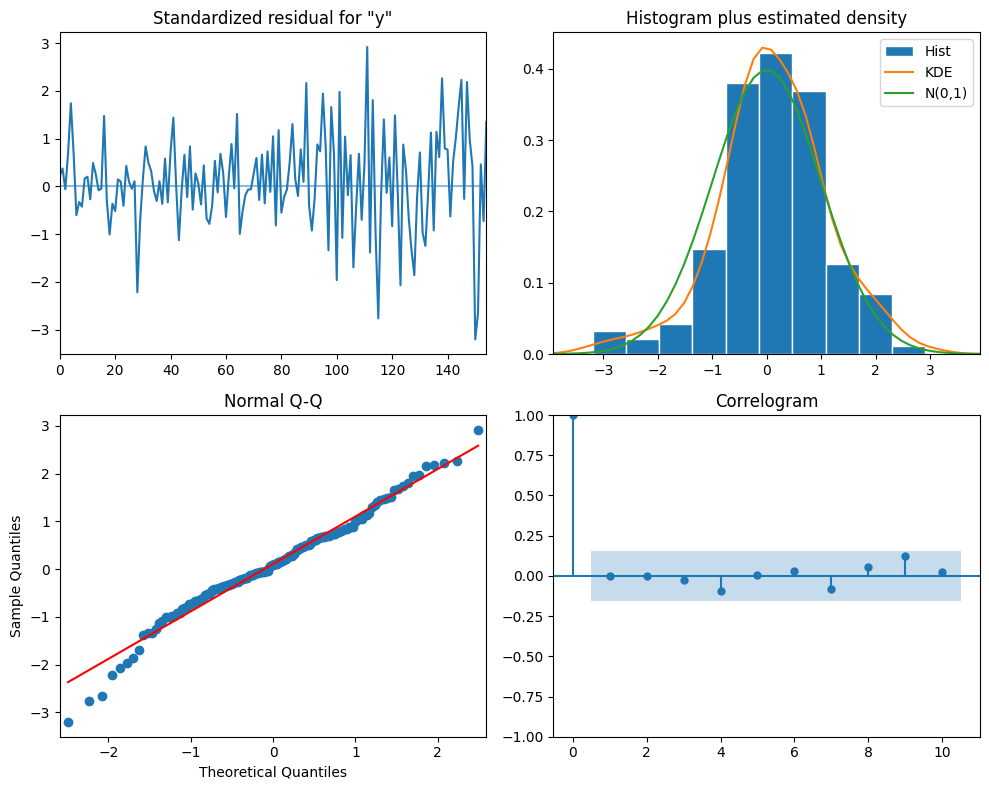

In [17]:
# let's analyze the residuals qualitatively

sarima_model.plot_diagnostics(figsize=(10,8))
plt.tight_layout()

the residuals are generally close to white noise. the Q-Q plots exhibits a line close to y=x. The historgam shows a distribution which is similar to a normal distribution. The correlogram shows no autocorrelation after lag 0

In [18]:
# let's perform the Ljung Box Statistics test

Residuals = sarima_model.resid

acorr_ljungbox(Residuals, lags=np.arange(1, 11, 1), return_df=True)

,lb_stat,lb_pvalue
1,0.436794,0.508674
2,0.627572,0.730675
3,0.646077,0.885808
4,2.258467,0.688341
5,2.950713,0.707584
6,3.389677,0.758585
7,9.982368,0.189575
8,10.592347,0.225884
9,11.854480,0.221638
10,11.985792,0.286009


All the p-values > 0.05, so we cannot reject the null hypothesis, therefore the residuals are independently distibuted. In other words, the residuals are uncorrelated

In [19]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len

    if method == 'last_season':
        pred_last_season = []
        
        for i in range(train_len, total_len, window):
            last_season = df['y'][i-window:i].values
            pred_last_season.extend(last_season)
            
        return pred_last_season
    
    elif method == 'SARIMA':
        pred_SARIMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df['y'][:i], order=(2,1,3), seasonal_order=(1,1,3,12), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMA.extend(oos_pred)
            
        return pred_SARIMA

In [31]:
# insert the parameters of the rolling_forecast function

Train_len  = len(train)
Horizon = len(test)
Window = 1

last_season = rolling_forecast(df, Train_len, Horizon, Window, 'last_season')
sarima = rolling_forecast(df, Train_len, Horizon, Window, 'SARIMA')

test.loc[:, 'last_season'] = last_season
test.loc[:, 'sarima'] = sarima

test.head()

,ds,y,last season,sarima,last_season
168,2005-07-01,15.829550,15.705248,16.751729,15.705248
169,2005-08-01,17.554701,15.829550,16.498258,15.829550
170,2005-09-01,18.100864,17.554701,17.185326,17.554701
171,2005-10-01,17.496668,18.100864,18.321086,18.100864
172,2005-11-01,19.347265,17.496668,18.964363,17.496668


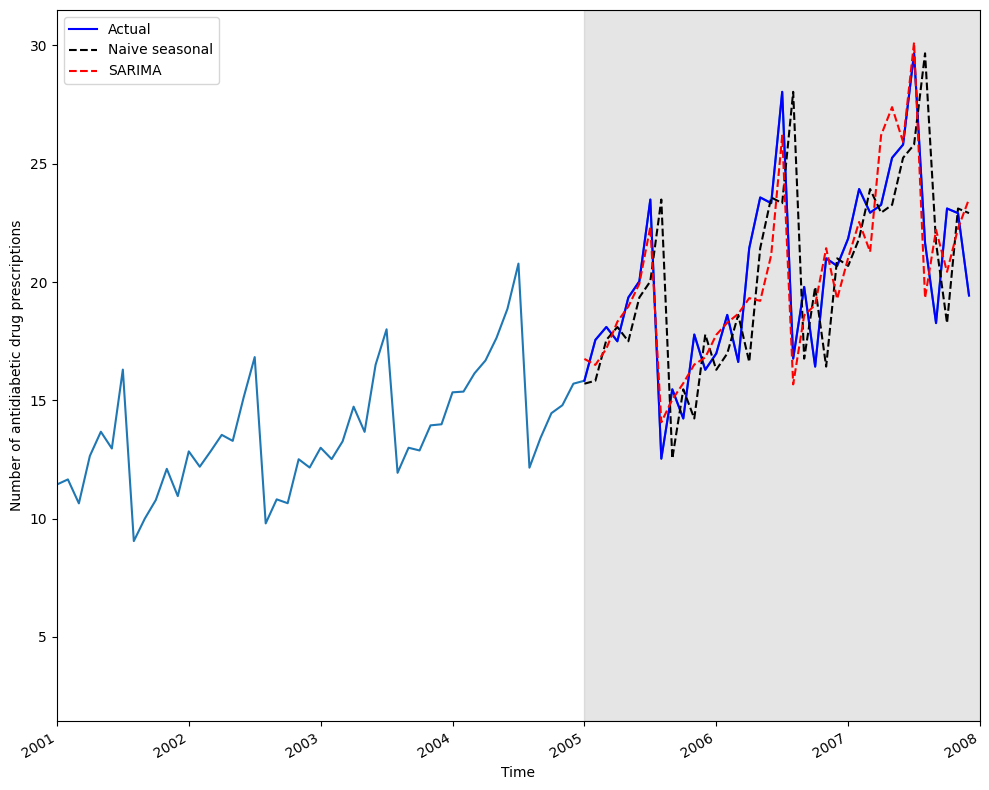

In [32]:
# let's plot the predictions

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(df['y'])
ax.plot(test['y'], 'b-', label='Actual')
ax.plot(test['last_season'], 'k--', label='Naive seasonal')
ax.plot(test['sarima'], 'r--', label='SARIMA')
ax.axvspan(168, 204, color='#808080', alpha=0.2)
ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Number of antidiabetic drug prescriptions')

plt.xticks(np.arange(0, 216, 12), np.arange(1991, 2009, 1))
ax.set_xlim(120, 204)

fig.autofmt_xdate()
plt.tight_layout()

In [33]:
# let's evaluate the model by calculating the Mean Absolute Percentage Error
# let's define a function to compute it

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [34]:
mape_naive_seasonal = mape(test.y, test.last_season)
mape_SARIMA = mape(test.y, test.sarima)

print(mape_naive_seasonal, mape_SARIMA)

14.652088487084217 7.576967832074849


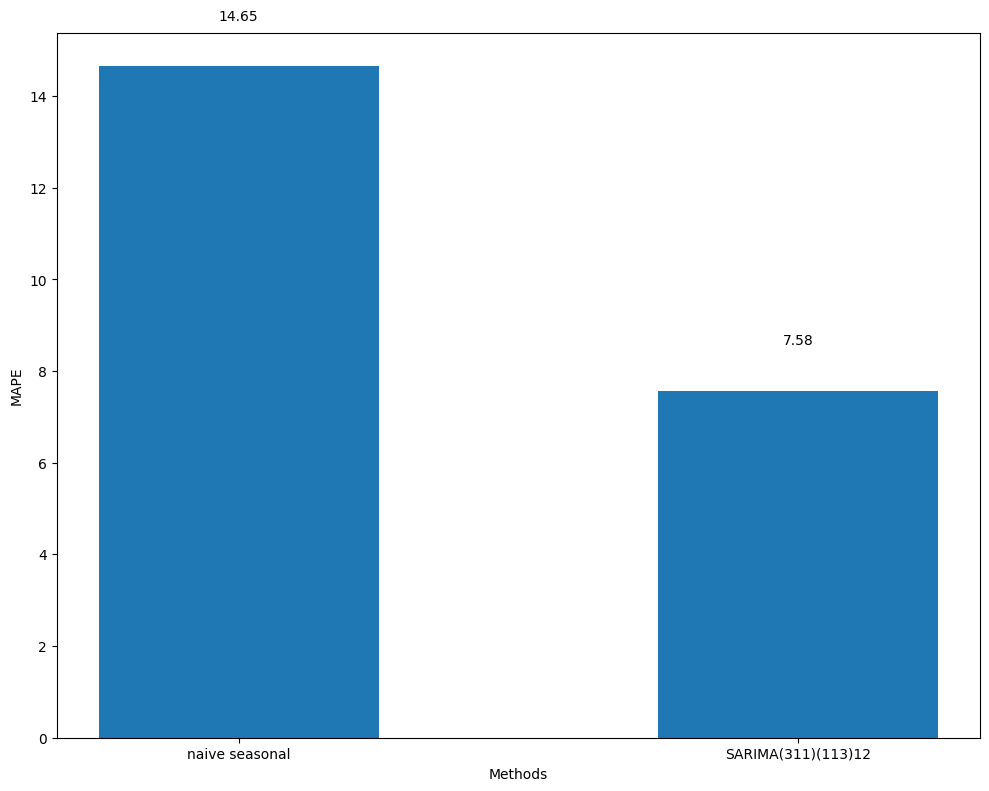

In [42]:
# let's plot the MAPE for both methods

fig, ax = plt.subplots(figsize=(10,8))

x = ['naive seasonal', 'SARIMA(311)(113)12']
y = [mape_naive_seasonal, mape_SARIMA]

ax.bar(x, y, width=0.5)
ax.set_xlabel('Methods')
ax.set_ylabel('MAPE')

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()